In [2]:
%matplotlib inline
import numpy as np
from scipy.signal import blackman, convolve, convolve2d
from scipy.misc import imread, imsave, face
from scipy.fftpack import fft, ifft, fft2, ifft2
import matplotlib.pyplot as plt

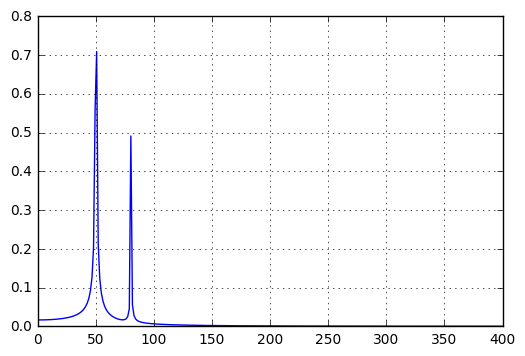

In [2]:
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
plt.grid()
plt.show()

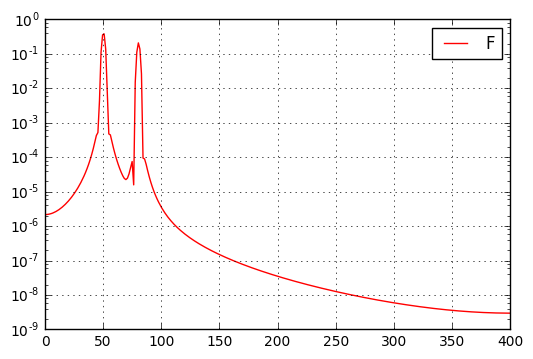

In [3]:
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
ywf = fft(y*blackman(N))
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
plt.semilogy(xf[1:N/2], 2.0/N * np.abs(ywf[1:N/2]), '-r')
plt.legend('FFT w. window')
plt.grid()
plt.show()

Равенство Парсеваля

In [4]:
E1 = np.sum(y * np.conj(y))
E2 = np.sum(fft(y)[1:N/2] * np.conj(fft(y)[1:N/2])) * 2.0/N
print E1, E2

374.375 (374.33297625+0j)


In [24]:
mu = 0
sigma = 0.5
n = np.random.normal(mu, sigma, N)
nf = fft(n)
E1 = np.sum(n * np.conj(n))
E2 = np.sum(nf * np.conj(nf)) * 1.0/N
print E1, E2, sigma**2 * N


122.952123941 (122.952123941+0j) 150.0


In [11]:
def deconv(c, b):
    Nout = len(c) - len(b) + 1
    b = np.pad(b, (0, len(c)-len(b)), "constant", constant_values=0)

    a = ifft(fft(c) / fft(b))
    a = np.real(a[:Nout])
    a[abs(a) < 1e-12] = 0.0
    return a

In [83]:
a = np.array([1, 2, 0, 3, 2, 5, 1, 0, 2])
b = np.array([3, 4, 0, 0, 1])
c = convolve(a, b)

print a
print deconv(c, b)

[1 2 0 3 2 5 1 0 2]
[ 1.  2.  0.  3.  2.  5.  1.  0.  2.]


In [84]:
def wiener_deconv(c, b, snr):
    Nout = len(c) - len(b) + 1
    b = np.pad(b, (0, len(c)-len(b)), "constant", constant_values=0)
    
    Fc = fft(c)
    Fb = fft(b)
    
    G = (Fb * np.conj(Fb)) / (Fb * np.conj(Fb) + 1 / snr) / Fb
    a = ifft(G * Fc)
    a = np.real(a[:Nout])
    a[abs(a) < 1e-12] = 0.0
    return a

In [94]:
def criteria(orig, reconstr):
    d = orig - reconstr
    return d.mean(), d.std()

In [177]:
mu = 0
sigma = 0.1
n = np.random.normal(mu, sigma, len(c))

Fa = fft(np.pad(a, (0, len(c)-len(a)), "constant", constant_values=0))
Fn = fft(n)
# Fa = np.pad(Fa, (0, len(Fn)-len(Fa)), "constant", constant_values=0)
SNR = 1e6 / sigma**2 #(Fn * Fn.conj())

print criteria(a, wiener_deconv(c + n, b, SNR))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


ValueError: operands could not be broadcast together with shapes (5,5) (5,7) 

In [59]:
def wiener_deconv2(c, b, snr):
    Nout = c.shape[0] - b.shape[0] + 1
    Mout = c.shape[1] - b.shape[1] + 1
    b = np.pad(b, [(0, Nout-1), (0, Mout-1)], "constant", constant_values=0)
    
    Fc = fft2(c)
    Fb = fft2(b)
    
    G = (Fb * np.conj(Fb)) / (Fb * np.conj(Fb) + np.ones(c.shape) / snr) / Fb
    a = ifft2(G * Fc)
    a = np.real(a[:Nout, :Mout])
    a[abs(a) < 1e-12] = 0.0
    return a

In [60]:
def wiener_deconv2_sigma(b, p, sigma):
    Nout = b.shape[0] - p.shape[0] + 1
    Mout = b.shape[1] - p.shape[1] + 1
    p = np.pad(p, [(0, Nout-1), (0, Mout-1)], "constant", constant_values=0)
    
    Fb = fft2(b)
    Fp = fft2(p)
    
    snr = (Fb * Fb.conj() + sigma**2) / (Fp * Fp.conj()) / sigma**2
    G = (Fp * Fp.conj()) / (Fp * Fp.conj() + 1.0 / snr) / Fp
    a = ifft2(G * Fb)
    a = np.real(a[:Nout, :Mout])
    a[abs(a) < 1e-12] = 0.0
    return a

In [61]:
a = np.array([[1, 2, 0, 3, 7], 
              [0, 10, 1, 1, 1], 
              [32, 12, 0, 0, 0],
              [2, 1, 3, 5, 0],
              [3, 0, 4, 2, 1]])

b = np.array([[1, 0, 1],
              [2, 1, 0],
              [0, 1, 1]])

In [62]:
c = convolve2d(a, b)

In [99]:
sigma = 0.2
n = np.random.normal(0, sigma, c.shape)
# Fa = fft2(np.pad(a, [(0, c.shape[0]-a.shape[0]), (0, c.shape[1]-a.shape[0])], "constant", constant_values=0))
snr = Fa * Fa.conj() / (sigma ** 2)
# print np.mean(Fa * Fa.conj()), sigma**2
# print snr.shape, c.shape
# print np.ones(c.shape) / snr
d = wiener_deconv2(c + n, b, 25)
print (d - a).std()
print d

0.368064588025
[[  1.16225618e+00   1.48447998e+00  -3.08868893e-01   3.43292925e+00
    6.51847182e+00]
 [  1.95324870e-01   9.68953037e+00   1.50476434e+00   1.18786273e+00
    9.90772894e-01]
 [  3.10786946e+01   1.19241715e+01  -1.43439472e-02   5.91365749e-02
   -5.79528251e-01]
 [  1.91574973e+00   1.19620047e+00   3.53852669e+00   4.87481491e+00
   -1.26452401e-01]
 [  2.71641941e+00   4.80930494e-01   3.88507703e+00   1.43062337e+00
    1.20465120e+00]]


Видно, что остается только гауссов шум с приблизительно таким же стандартным отклонением

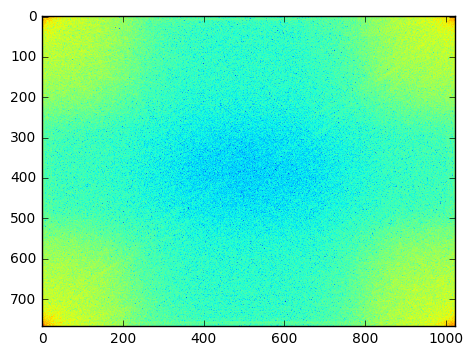

In [113]:
from scipy.misc import face
image = face(gray=True)
freq = fft2(image)
freq = np.abs(freq)

plt.imshow(np.log(freq))
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
# ax[0,0].hist(freq.ravel(), bins=100)
# ax[0,0].set_title('hist(freq)')
# ax[0,1].hist(np.log(freq).ravel(), bins=100)
# ax[0,1].set_title('hist(log(freq))')
# ax[1,0].imshow(np.log(freq), interpolation="none")
# ax[1,0].set_title('log(freq)')
# ax[1,1].imshow(image, interpolation="none")
# plt.show()